In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import DataLoader


from models.unet import Unet

import matplotlib.pyplot as plt
import numpy as np

from utils.utils import show_image
from utils.noise import CosineNoiseAdder

from data.dataset import MNIST_Dataset, CIFAR10_Dataset

from tqdm import tqdm

In [2]:
# testing net shapes
net = Unet(64, depth=3, time_embed_dim=32, label_emb_dim=32,
           num_label=10, initial_channels=1, conv_layers=2)
test_img = torch.randn(1, 1, 32, 32)
test_time = torch.tensor([1])
test_label = torch.tensor([1])
print(net(test_img, test_time, test_label, verbose=True).shape)

start with shape torch.Size([1, 1, 32, 32])
label shape : torch.Size([1])
label_embeddings shape : torch.Size([1, 32])
label_embeddings shape : torch.Size([1, 32, 1, 1])
label_embeddings shape : torch.Size([1, 32, 32, 32])
after concatenating the timestep embedds : torch.Size([1, 65, 32, 32])
down block 0, with shape torch.Size([1, 65, 32, 32])
down block 1, with shape torch.Size([1, 64, 16, 16])
down block 2, with shape torch.Size([1, 128, 8, 8])
after bottleneck : shape = torch.Size([1, 256, 8, 8])
up block 0, with shape torch.Size([1, 256, 8, 8]), and skip shape : torch.Size([1, 256, 8, 8])
up block 1, with shape torch.Size([1, 128, 16, 16]), and skip shape : torch.Size([1, 128, 16, 16])
after final : shape = torch.Size([1, 1, 32, 32])
torch.Size([1, 1, 32, 32])


## Set up

In [3]:
class CFG:
    # dataset
    batch_size = 4
    
    # noise
    B_0 = 1e-4
    B_T = 2e-2
    T = 500
    schedule_type = 'cosine'
    s = 0.008

## Noise Dataset

In [4]:
class NoiseDataset():
    def __init__(self, imgs_dataset, noise_schedule = None):
        self.imgs_dataset = imgs_dataset
        self.noise_schedule = noise_schedule if noise_schedule else CosineNoiseAdder()       

    def __getitem__(self, idx):
        img, label = self.imgs_dataset[idx]
        t = torch.randint(self.noise_schedule.T, (1, )).squeeze()
        noisy_img, noise = self.noise_schedule.image_at_time_step(img, t)
        return noisy_img, noise, t, label

    def __len__(self):
        return len(self.imgs_dataset)

## Training

### Weight Initialization

In [5]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight, gain=1)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)


In [6]:
def eval_model(model:nn.Module, _test_loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for i, (noisy_imgs, noises, time_steps, labels) in enumerate(_test_loader):
            noisy_imgs, noises, time_steps, labels = noisy_imgs.to(device), noises.to(device), time_steps.to(device), labels.to(device)
            outputs = model(noisy_imgs, time_steps, labels)
            loss = criterion(outputs, noises)
            losses.append(loss.item())
            # print(loss, losses)
            # print(f"Batch {i}, Loss: {loss.item()}")
    return sum(losses)/len(losses)

### Training Loop

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


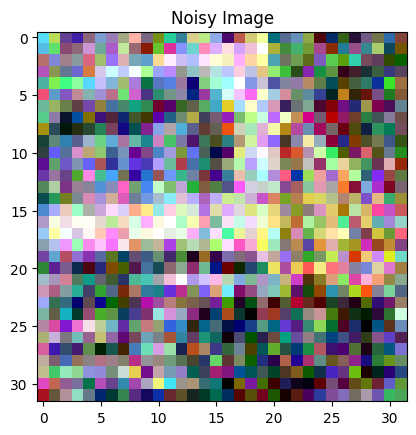

In [7]:
# hyperparameters
n_epochs = 20
batch_size = 16
lr = 1e-3
dropout = 0.2
max_time_steps = 200
patience = 6000


test = None
train = None
net = None

CosineNoise = CosineNoiseAdder(max_time_steps)


# dataset = "MNIST"
dataset = "CIFAR10"

if dataset == "MNIST":
    initial_channels = 1
    trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5,), (0.5, ))])
    
    train = NoiseDataset(MNIST_Dataset(transform=trans), CosineNoise)
    test = NoiseDataset(MNIST_Dataset('test', transform=trans), CosineNoise)
    
    net = Unet(32, depth=2, time_embed_dim=16, label_emb_dim=16,
           num_label=10, initial_channels=initial_channels, 
           conv_layers=3, dropout=dropout)

if dataset == "CIFAR10":
    initial_channels = 3
    trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    train = NoiseDataset(CIFAR10_Dataset(transform=trans), CosineNoise)
    test = NoiseDataset(CIFAR10_Dataset(transform=trans, split='test'), CosineNoise)
    
    net = Unet(64, depth=3, time_embed_dim=16, label_emb_dim=32,
           num_label=10, initial_channels=initial_channels, 
           conv_layers=2, dropout=dropout)

show_image(train[1][0], title="Noisy Image")

In [8]:
# train = torch.utils.data.Subset(train, range(0, 1000))
# test = torch.utils.data.Subset(test, range(0, 100))
train_loader = DataLoader(train, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test, shuffle=False, batch_size=batch_size)

net.apply(init_weights)


# loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.316)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=n_epochs * len(train_loader), eta_min=1e-5)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=50, min_lr=1e-4)


Using device: cuda


Epoch 12/20:  30%|██▉       | 936/3125 [01:00<02:21, 15.44it/s, Loss=0.043, Val Loss=0.0633, lr=0.000405] 

Stopping early


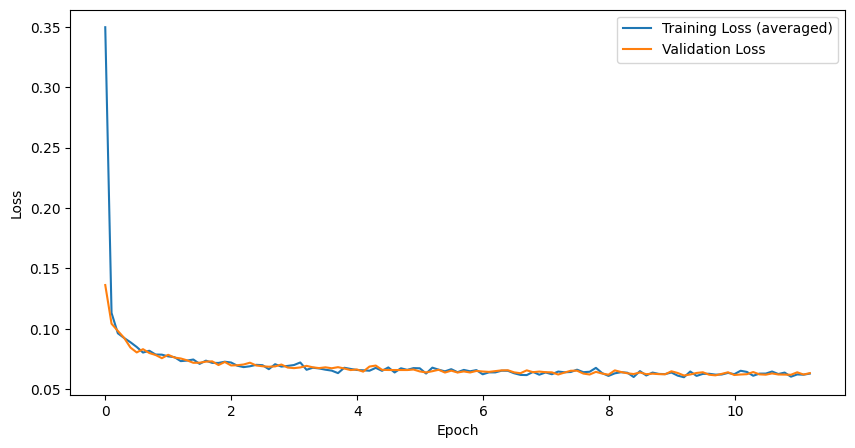

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
net.to(device)

# keep track of the loss
train_losses = []
val_losses = []
best_loss = np.inf
best_loss_i = 0
stoping = False
eval_every = len(train_loader) // 10

net.train()
# training loop
for epoch in range(n_epochs):
    train_loader_tqdm = tqdm(train_loader, desc=f'Epoch {epoch+1}/{n_epochs}', leave=True)
    for i, batch in enumerate(train_loader_tqdm):
        noisy_imgs, noises, time_steps, labels = batch
        noisy_imgs, noises, time_steps, labels = noisy_imgs.to(
            device), noises.to(device), time_steps.to(device), labels.to(device)
        # print(noisy_imgs.shape, noises.shape, time_steps.shape, labels.shape)

        optimizer.zero_grad()

        predicted_noise = net(noisy_imgs, time_steps, labels, verbose=False)
        loss = criterion(predicted_noise, noises)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
        optimizer.step()

        train_losses.append(loss.item())

        if i % eval_every == 0 and i > 0:
            
            val_loss = eval_model(net, test_loader, criterion, device)
            val_losses.append(val_loss)
            # print(f'Epoch [{epoch+1}/{n_epochs}], Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, lr: {scheduler.get_last_lr()[0]}')
            train_loader_tqdm.set_postfix({'Loss': loss.item(), 'Val Loss': val_loss, 'lr': scheduler.get_last_lr()[0]})

            
            if val_loss < best_loss:
                best_loss = val_loss
                best_loss_i = epoch * len(train_loader) + i
                torch.save(net.state_dict(), 'best_model_MNIST.pth')

            if epoch * len(train_loader) + i - best_loss_i > patience:
                print("Stopping early")
                stoping = True
                break

        # show_image(noisy_imgs[0], title="noisy image")
        # show_image(predicted_noise[0], title="predicted noise")

        # break
        scheduler.step()
        # train_loader_tqdm.set_postfix({'Loss': loss.item(), 'Val Loss': val_loss, 'lr': scheduler.get_last_lr()[0]})
    # if epoch % 4 == 0:
    #     scheduler.step()
    if stoping:
        break
    # break

plt.figure(figsize=(10, 5))
train_losses_resized = [np.mean(train_losses[i * eval_every:(i + 1) * eval_every]) for i in range(len(val_losses))]
plt.plot(np.arange(0, len(train_losses_resized)) * eval_every / len(train_loader), train_losses_resized, label='Training Loss (averaged)')
plt.plot(np.arange(0, len(val_losses)) * eval_every / len(train_loader), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
net.load_state_dict(torch.load('best_model_MNIST.pth'))
net.eval()

Unet(
  (time_emb): TimeEmbedding(
    (time_mlp): Sequential(
      (0): SinusoidalPositionEmbeddings()
      (1): Linear(in_features=16, out_features=16, bias=True)
      (2): SiLU()
      (3): Linear(in_features=16, out_features=16, bias=True)
    )
  )
  (label_emb): LabelEmbedding(
    (emb): Embedding(10, 32)
    (proj): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): SiLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    )
  )
  (down_blocks): ModuleList(
    (0): DownBlock(
      (silu): SiLU()
      (convs): ModuleList(
        (0): Conv2d(51, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (norms): ModuleList(
        (0-1): 2 x BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (dropouts): ModuleList(
        (0-1): 2 x Dropout(p=0.2, inplace=False)
      )
      (max_pooling): Ma

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


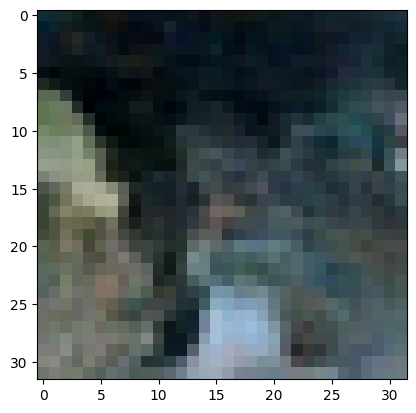

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


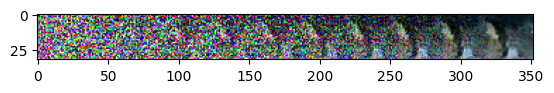

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


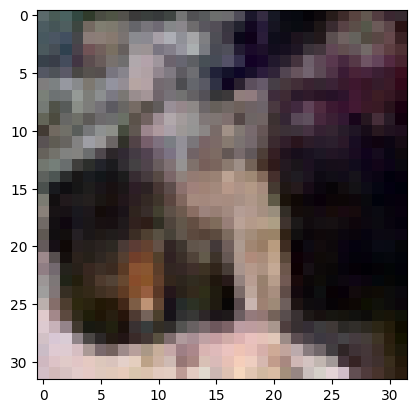

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


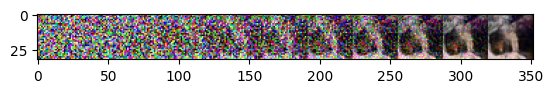

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


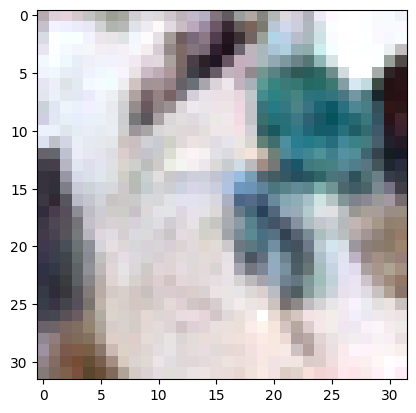

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


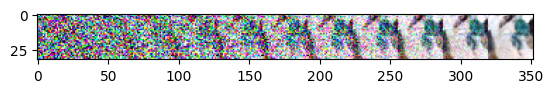

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


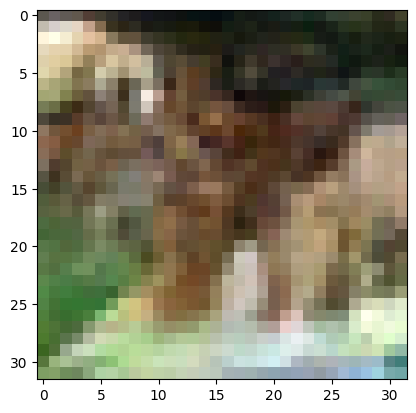

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


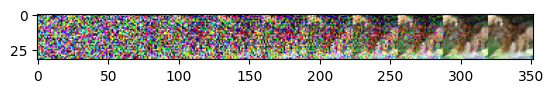

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


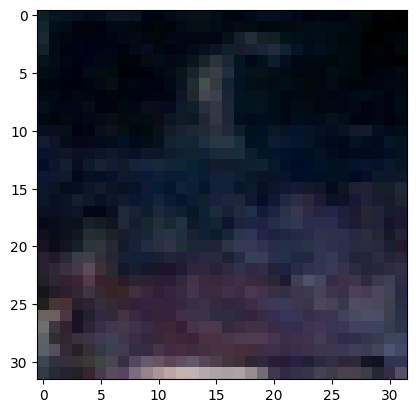

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


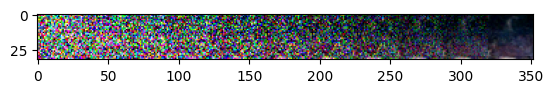

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


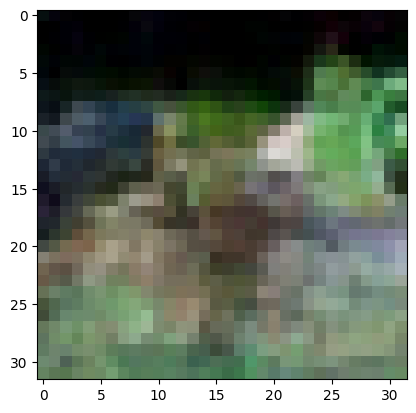

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


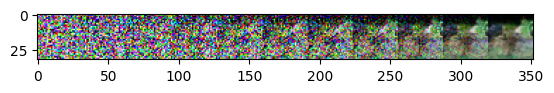

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


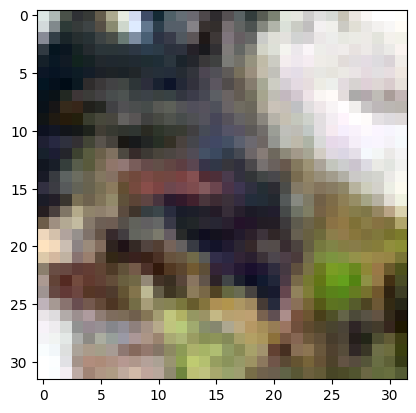

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


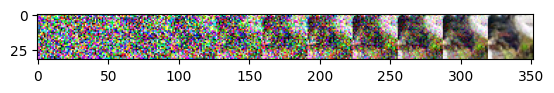

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


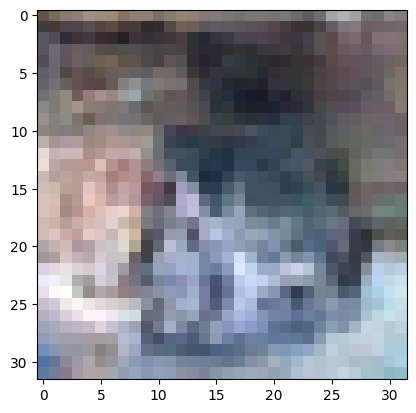

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


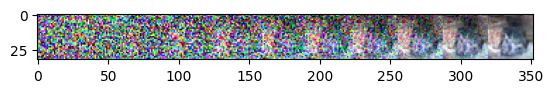

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


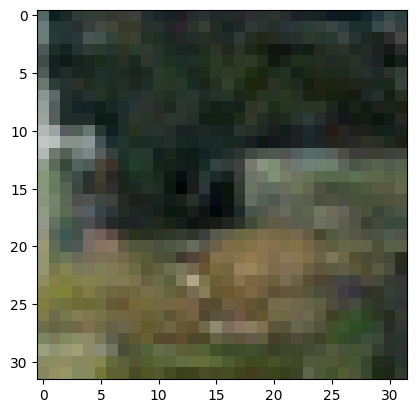

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


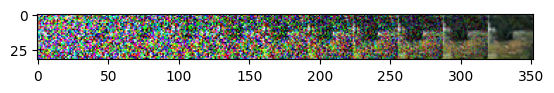

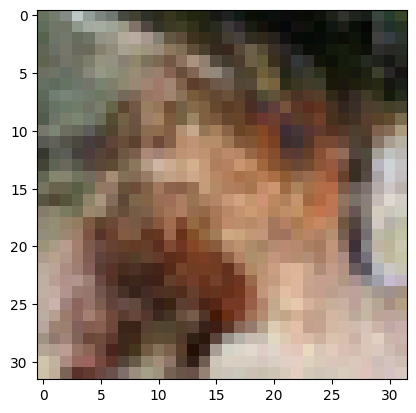

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


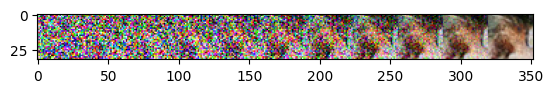

In [13]:
max_time_steps = 200

n_samples = 1
xt = torch.randn((n_samples, initial_channels, 32, 32)).to(device)
T = max_time_steps
s = 0.008

# 'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
label = torch.tensor([6], device=device)

CosineNoise = CosineNoiseAdder(max_time_steps, s)

# print(CosineNoise.get_alpha_t(T))
for _ in range(10):
    with torch.no_grad():
        full_img = torch.tensor([], device=device)
        full_predicted_noise = torch.tensor([], device=device)
    
        xt = torch.randn((n_samples, initial_channels, 32, 32)).to(device)
        for t in torch.arange(max_time_steps-1, -1, -1):
            t = t.expand((n_samples)).to(device)
            a_t = CosineNoise.get_alpha_t(t)
            alpha_t_barre = CosineNoise.get_alpha_t_barre(t)
            sigma = torch.sqrt(1-a_t).view(n_samples, 1, 1, 1)
            z = torch.randn_like(xt)
            # print(xt.shape)
            epsilon = net(xt, t, label)
            a = ((1 - a_t)/(torch.sqrt(1 - alpha_t_barre))).view(n_samples, 1, 1, 1)
            b = (1/torch.sqrt(a_t)).view(n_samples, 1, 1, 1)
            
            if t.item() % (max_time_steps / 10) == 0 or t.item() == max_time_steps-1:
                # print(t.item())
                full_img = torch.cat((full_img, xt), 3)
                full_predicted_noise = torch.cat((full_predicted_noise, epsilon), 3)
                # print(xt.shape)
                # show_image(xt[0], f'{t.item()}%')
                # show_image(full_img[0])
            
            # print(t[0].item(), a_t[0].item(), alpha_t_barre[0].item(), sigma[0].item(), a[0].item(), b[0].item(), z.shape, epsilon.shape, sep=' | ')
            # print(xt.shape, epsilon.shape)
            
            xt = b*(xt - a*epsilon) + sigma*z

            # xt = torch.sqrt(1 - a_t).view(n_samples, 1, 1, 1) * epsilon + sigma * z
            
            # xt = b * (xt - torch.sqrt(1-alpha_t_barre)*epsilon) + sigma*z
            
            # print(xt[0][0][0][0], xt[0][1][0][0], xt[0][2][0][0])
            # print(xt[0])

        show_image(xt[0])
        
    # print(full_img.shape)
        show_image(full_img[0])
        # show_image(full_predicted_noise[0])